In [1]:
import sys
sys.path.append('../code') 
import mocap_functions
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from sklearn.model_selection import ShuffleSplit
import scipy.io as sio
import multiprocessing
import Neural_Decoding
from torch import nn

num_cores = multiprocessing.cpu_count()


/home/ntolley/anaconda3/envs/SEE_vision/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '../data/SPK20220308/task_data/'
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df(data_path)
video_df = pd.read_pickle(data_path + 'video_df.pkl')


num_trials = metadata['num_trials']

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [3]:
# Filter dataframes add or remove layout info
nolayout_neural_mask = ~(neural_df['unit'].str.contains(pat='layout'))
noposition_neural_mask = ~(neural_df['unit'].str.contains(pat='position'))
neural_df = neural_df[np.logical_and(nolayout_neural_mask, noposition_neural_mask)]

In [4]:
reader = torchvision.io.VideoReader('../data/SPK20220308/videos/SpikeCam1_03-08-1557.mp4', 'video')

In [5]:
analog_sampling_rate = 1000
cam_frames = np.load('cam_frames.npy')

fpath = '../data/SPK20220308/task_data/'
experiment_dict = sio.loadmat(f'{fpath}eventsCB1_corrected.mat')
ev_ex = experiment_dict['eventsCB1']

cam_start = cam_frames[0] / analog_sampling_rate

In [6]:
# frame_data_list = list()
# pooler = torch.nn.AvgPool2d(kernel_size=100, stride=50)
# for idx  in range(len(video_df)):
#     print(idx, end=' ')
#     frame_times = video_df['frames'][idx]
#     frame_trial = list()
#     for ftime in frame_times:
#         reader.seek(ftime - cam_start)
#         frame = next(reader)
#         frame_pooled = pooler(frame['data'].float())
#         frame_trial.append(frame_pooled[0, :, :].reshape(-1))

#     frame_data_list.append(frame_trial)
#     np.save(f'../data/SPK20220308/frames/frame_trial{idx}.npy', torch.vstack(frame_trial).numpy())

In [7]:
frame_data_list = list()
for idx in range(len(video_df)):
    frame_trial = np.load(f'../data/SPK20220308/frames/frame_trial{idx}.npy')
    frame_data_list.append(frame_trial)

In [8]:
# pooler = torch.nn.AvgPool2d(kernel_size=100, stride=50)
# for idx in range(60):
#     print(idx, end=' ')
#     reader.seek(video_df['frames'][0][idx] - cam_start)
#     frame = next(reader)
#     plt.figure(figsize=(10,5))
#     plt.subplot(1,2,1)
#     plt.imshow(frame['data'].numpy()[0,:,:])

#     plt.subplot(1,2,2)
#     frame_pooled = pooler(frame['data'].float())
#     plt.imshow(frame_pooled[0,:,:])

#     plt.savefig(f'../data/SPK20220308/frames/frame{idx}.png')
#     plt.close()

In [9]:
# images = [f'frame{idx}.png' for idx in range(60)]
# mocap_functions.make_movie('../data/SPK20220308/frames/', 'pooling_layer.mp4', images, fps=30, quality=10)

In [10]:
# Dataset class to handle mocap dataframes from SEE project
class SEE_Video_Dataset(torch.utils.data.Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, cv_dict, fold, partition, video_df, neural_df, reader,
                 offset, window_size, data_step_size, device, cam_start,
                 scale_neural=True, flip_outputs=False, scaler=None):
        #'Initialization'
        self.cv_dict = cv_dict
        self.fold = fold
        self.flip_outputs = flip_outputs
        self.partition = partition
        self.trial_idx = cv_dict[fold][partition]
        self.num_trials = len(self.trial_idx) 
        self.offset = offset
        self.window_size = window_size
        self.data_step_size = data_step_size
        self.device = device
        self.videoData_list, self.neuralData_list = self.process_dfs(video_df, neural_df)
        #self.pooler = torch.nn.AvgPool2d(kernel_size=100, stride=50)
        #self.pooler = torch.nn.AvgPool2d(kernel_size=10, stride=5)
        self.reader = reader
        self.cam_start = cam_start

        if scaler is None:
            self.scaler = StandardScaler()
        else:
            self.scaler = scaler
        
        if scale_neural:
            self.neuralData_list = self.transform_data(self.neuralData_list)

        self.split_offset = np.round((self.offset/self.data_step_size) / 2).astype(int)

        self.X_tensor, self.y_tensor = self.load_splits()
        self.num_samples = np.sum(self.X_tensor.size(0))

    def __len__(self):
        #'Denotes the total number of samples'
        return self.num_samples

    # Need to modify if flipouts is ever enabled
    def __getitem__(self, slice_index):
    
        # frame_data = list()
        # if slice_index is None:
        #     frame_times = self.X_tensor.squeeze()
        # else:
        #     frame_times = self.X_tensor[slice_index, :, :].squeeze()

        # #print(frame_times)
        
        # for ftime in frame_times:
        #     self.reader.seek(ftime - self.cam_start)
        #     frame = next(self.reader)
        #     frame_pooled = self.pooler(frame['data'].float())
        #     frame_data.append(frame_pooled[0, :, :].reshape(-1))

        # frame_data = torch.vstack(frame_data)
        # if slice_index is None:
        #     frame_data = frame_data[None]

        return self.X_tensor[slice_index,:,:], self.y_tensor[slice_index,:,:]

    def process_dfs(self, video_df, neural_df):
        frame_list, neuralData_list = list(), list()
        for trial in self.trial_idx:
            #frame_array = np.stack(video_df['frames'][video_df['trial'] == trial].values).transpose() 
            neuralData_array = np.stack(neural_df['rates_video'][neural_df['trial'] == trial].values).squeeze().transpose()

            frame_list.append(frame_data_list[trial])
            neuralData_list.append(neuralData_array)
        
        return frame_list, neuralData_list

    def format_splits(self, data_list):
        unfolded_data_list = list()
        for trial_idx in range(self.num_trials):
            unfolded_trial = torch.from_numpy(data_list[trial_idx]).unfold(0, self.window_size, self.data_step_size).transpose(1, 2)
            unfolded_data_list.append(unfolded_trial)
        
        data_tensor = torch.concat(unfolded_data_list, axis=0)

        return data_tensor
    
    def load_splits(self):
        if not self.flip_outputs:
            X_tensor = self.format_splits(self.videoData_list)
            y_tensor = self.format_splits(self.neuralData_list)
        else:
            y_tensor = self.format_splits(self.videoData_list)
            X_tensor = self.format_splits(self.neuralData_list)

        X_tensor, y_tensor = X_tensor[:-self.split_offset,::self.data_step_size,:], y_tensor[self.split_offset:,::self.data_step_size,:]

        assert X_tensor.shape[0] == y_tensor.shape[0]
        return X_tensor, y_tensor

    #Zero mean and unit std
    def transform_data(self, data_list):
        #Iterate over trials and apply normalization
     
        scaled_data_list = []
        for data_trial in data_list:
            scaled_data_trial = self.scaler.fit_transform(data_trial)
            scaled_data_list.append(scaled_data_trial)

        return scaled_data_list

In [11]:
# Set up PyTorch Dataloaders
fold=0
scale_neural = True
flip_outputs = False
device = 'cpu'

data_step_size = 1
# Parameters
batch_size = 10000
train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

In [12]:
training_set = SEE_Video_Dataset(cv_dict=cv_dict, fold=fold, partition='train_idx', video_df=video_df,
                                 neural_df=neural_df, reader=reader, offset=10, window_size=1,
                                 data_step_size=data_step_size, device=device, cam_start=cam_start,
                                 scale_neural=scale_neural, flip_outputs=flip_outputs, scaler=None)

In [13]:
def make_generators_video(video_df, neural_df, offset, cv_dict, window_size=1, device='cpu'):
    # Set up PyTorch Dataloaders
    fold=0
    scale_neural = True
    flip_outputs = False
    device = 'cpu'

    data_step_size = 1
    
    # Parameters
    batch_size = 10000
    train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
    validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}


    # Generators
    training_set = SEE_Video_Dataset(cv_dict=cv_dict, fold=fold, partition='train_idx', video_df=video_df,
                                 neural_df=neural_df, reader=reader, offset=offset, window_size=window_size,
                                 data_step_size=data_step_size, device=device, cam_start=cam_start,
                                 scale_neural=scale_neural, flip_outputs=flip_outputs, scaler=None)
    training_generator = torch.utils.data.DataLoader(training_set, **train_params)
    training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)

    validation_set = SEE_Video_Dataset(cv_dict=cv_dict, fold=fold, partition='validation_idx', video_df=video_df,
                                 neural_df=neural_df, reader=reader, offset=offset, window_size=window_size,
                                 data_step_size=data_step_size, device=device, cam_start=cam_start,
                                 scale_neural=scale_neural, flip_outputs=flip_outputs, scaler=None)

    validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

    testing_set = SEE_Video_Dataset(cv_dict=cv_dict, fold=fold, partition='test_idx', video_df=video_df,
                                 neural_df=neural_df, reader=reader, offset=offset, window_size=window_size,
                                 data_step_size=data_step_size, device=device, cam_start=cam_start,
                                 scale_neural=scale_neural, flip_outputs=flip_outputs, scaler=None)

    testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)

    data_arrays = (training_set, validation_set, testing_set)
    generators = (training_generator, training_eval_generator, validation_generator, testing_generator)

    return data_arrays, generators 

In [23]:
def run_wiener_video(video_df, neural_df, offset, cv_dict, window_size):
    data_arrays, generators = make_generators_video(video_df, neural_df, offset, cv_dict, window_size=window_size)

    # Unpack tuple into variables
    training_set, validation_set, testing_set = data_arrays
    training_generator, training_eval_generator, validation_generator, testing_generator = generators

    X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

    X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

    #Fit and run wiener filter
    model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
    model_wr.fit(X_train_data,y_train_data)

    wr_train_pred = model_wr.predict(X_train_data)
    wr_test_pred = model_wr.predict(X_test_data)

    #Compute decoding
    wr_train_corr = mocap_functions.matrix_corr(wr_train_pred,y_train_data)
    wr_test_corr = mocap_functions.matrix_corr(wr_test_pred,y_test_data)

    return wr_train_pred, wr_test_pred, wr_train_corr, wr_test_corr

def run_ann_video(video_df, neural_df, offset, cv_dict, window_size):
    data_arrays, generators = make_generators_video(video_df, neural_df, offset, cv_dict, window_size=window_size)

    # Unpack tuple into variables
    training_set, validation_set, testing_set = data_arrays
    training_generator, training_eval_generator, validation_generator, testing_generator = generators

    X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

    X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

    #Define hyperparameters
    lr = 1e-4
    weight_decay = 1e-5
    layer_size=[200, 200, 200]
    max_epochs=1000
    input_size = training_set[0][0].shape[1]
    output_size = training_set[0][1].shape[1] 

    model_ann = mocap_functions.model_ann(input_size,output_size,layer_size).to(device)
    # Define Loss, Optimizerints h
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_ann.parameters(), lr=lr, weight_decay=weight_decay)

    #Train model
    loss_dict = mocap_functions.train_validate_model(model_ann, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

    #Evaluate trained model
    ann_train_pred = mocap_functions.evaluate_model(model_ann, training_eval_generator, device)
    ann_test_pred = mocap_functions.evaluate_model(model_ann, testing_generator, device)
    
    #Compute decoding
    ann_train_corr = mocap_functions.matrix_corr(ann_train_pred,y_train_data)
    ann_test_corr = mocap_functions.matrix_corr(ann_test_pred,y_test_data)

    return ann_train_pred, ann_test_pred, ann_train_corr, ann_test_corr
    

In [24]:
window_size = 10
offset = 2

func_dict = {'wiener': run_wiener_video, 'rnn': run_ann_video}
#func_dict = {'wiener': run_wiener_video}
#func_dict = {'wiener': run_ann_video}

df_dict = {'video': {'df': video_df}}

decode_results = dict()
for func_name, func in func_dict.items():
    decode_results[func_name] = dict()
    for df_type, pred_df in df_dict.items():
        train_pred, test_pred, train_corr, test_corr = func(video_df, neural_df, offset, cv_dict, window_size)

        decode_results[func_name][df_type] = {
            'train_pred': train_pred,
            'test_pred': test_pred,
            'train_corr': train_corr,
            'test_corr': test_corr
        }



/home/ntolley/anaconda3/envs/SEE_vision/lib/python3.7/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


**********
Epoch: 10/1000 ... Train Loss: 0.9218  ... Validation Loss: 0.9193
**********
Epoch: 20/1000 ... Train Loss: 0.9017  ... Validation Loss: 0.9001
**********
Epoch: 30/1000 ... Train Loss: 0.8784  ... Validation Loss: 0.8790
**********
Epoch: 40/1000 ... Train Loss: 0.8496  ... Validation Loss: 0.8543
**********
Epoch: 50/1000 ... Train Loss: 0.8207  ... Validation Loss: 0.8298
**********
Epoch: 60/1000 ... Train Loss: 0.7983  ... Validation Loss: 0.8122
**********
Epoch: 70/1000 ... Train Loss: 0.7850  ... Validation Loss: 0.8018
****.**.**
Epoch: 80/1000 ... Train Loss: 0.7784  ... Validation Loss: 0.7964
.******..*
Epoch: 90/1000 ... Train Loss: 0.7746  ... Validation Loss: 0.7929
**.**.*.*.
Epoch: 100/1000 ... Train Loss: 0.7719  ... Validation Loss: 0.7908
**.***.*.*
Epoch: 110/1000 ... Train Loss: 0.7694  ... Validation Loss: 0.7882
.*.*...**.
Epoch: 120/1000 ... Train Loss: 0.7670  ... Validation Loss: 0.7871
.*...*.**.
Epoch: 130/1000 ... Train Loss: 0.7646  ... Valida

In [25]:
data_arrays, generators = make_generators_video(video_df, neural_df, offset, cv_dict, window_size=window_size)


# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

(-0.05, 0.9)

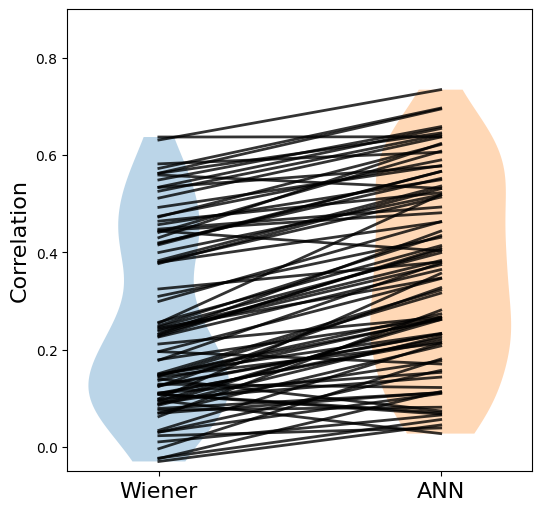

In [26]:
plt.figure(figsize=(6,6))
wiener_test_corr = decode_results['wiener']['video']['test_corr']
rnn_test_corr = decode_results['rnn']['video']['test_corr']

plot_data = np.stack([wiener_test_corr, rnn_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=['Wiener', 'ANN'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(wiener_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(rnn_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.ylim([-0.05,0.9])

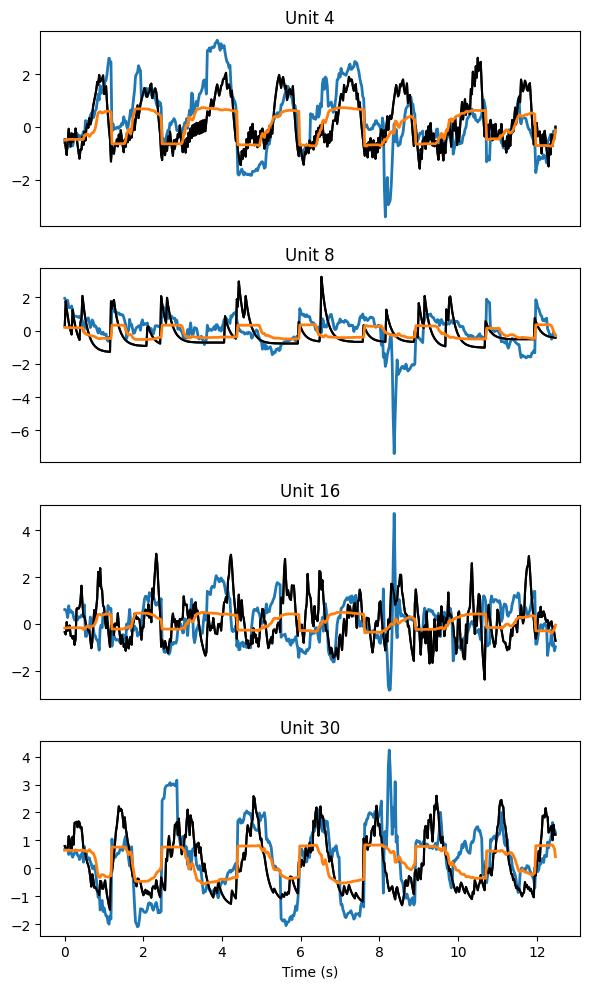

In [29]:
unit_list = [4, 8, 16, 30]
bounds = np.arange(0,500)
x_vals = np.arange(len(bounds))/40

plt.figure(figsize=(6,10))
for row_idx, unit_idx in enumerate(unit_list):
    plt.subplot(len(unit_list), 1, row_idx+1)
    plt.title(f'Unit {unit_idx}')
    for plot_idx, name in enumerate(['wiener', 'rnn']):

        plt.plot(x_vals, y_test_data[bounds,unit_idx], color='k')
        plt.plot(x_vals, decode_results[name]['video']['test_pred'][bounds, unit_idx], color=f'C{plot_idx}', linewidth=2, label=name)

        plt.ylim(plt.ylim())
        #plt.ylim([-3, 3.7])
        
        #plt.ylabel('Firing Rate (a.u.)')
            
        if row_idx + 1 == len(unit_list):
            plt.xlabel('Time (s)')
        else:
            plt.xticks([])

    plt.tight_layout()